# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here](http://nlp.stanford.edu:8080/corenlp/) to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

In [3]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For NLP
import nltk

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

%matplotlib inline

You need to run this _once_ to download everything, you will also need [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) if you are using Windows or MacOS.

In [4]:
lucem_illud.setupStanfordNLP()

Starting downloads, this will take 5-10 minutes
../stanford-NLP/parser already exists, skipping download
../stanford-NLP/ner already exists, skipping download
../stanford-NLP/postagger already exists, skipping download
../stanford-NLP/core already exists, skipping download
Done setting up the Stanford NLP collection


We need to have stanford-NLP setup before importing, so we are doing the import here. IF you have stanford-NLP working, you can import at the beginning like you would with any other library.

In [5]:
import lucem_illud.stanford as stanford

/anaconda3/lib/python3.6/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/anaconda3/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


Open Information Extraction is a module packaged within the Stanford Core NLP package, but it is not yet supported by `nltk`. As a result, we have defining our own `lucem_illud` function that runs the Stanford Core NLP java code right here. For other projects, it is often useful to use Java or other programs (in C, C++) within a python workflow, and this is an example. `stanford.openIE()` takes in a string or list of strings and then produces as output all the subject, verb, object (SVO) triples Stanford Corenlp can find, as a DataFrame. You can do this through links to the Stanford Core NLP project that we provide here, or play with their interface directly (in the penultimate cell of this notebook), which produces data in "pretty graphics" like this example parsing of the first sentence in the "Shooting of Trayvon Martin" Wikipedia article:

![Output 1](../data/stanford_core1.png)
![Output 2](../data/stanford_core2.png)

First, we will illustrate these tools on some *very* short examples:

In [7]:
text = ['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [nltk.word_tokenize(t) for t in text]
print('\n'.join(text))

I saw the elephant in my pajamas.
The quick brown fox jumped over the lazy dog.
While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.
Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. The Stanford POS tagger uses the [Penn Treebank tag set]('http://repository.upenn.edu/cgi/viewcontent.cgi?article=1603&context=cis_reports') to POS tag words from input sentences. As discussed in the second assignment, this is a relatively precise tagset, which allows more informative tags, and also more opportunities to err :-).

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

In [8]:
pos_sents = stanford.postTagger.tag_sents(tokenized_text)
print(pos_sents)

[[('I', 'PRP'), ('saw', 'VBD'), ('the', 'DT'), ('elephant', 'NN'), ('in', 'IN'), ('my', 'PRP$'), ('pajamas', 'NNS'), ('.', '.')], [('The', 'DT'), ('quick', 'JJ'), ('brown', 'JJ'), ('fox', 'NN'), ('jumped', 'VBD'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN'), ('.', '.')], [('While', 'IN'), ('in', 'IN'), ('France', 'NNP'), (',', ','), ('Christine', 'NNP'), ('Lagarde', 'NNP'), ('discussed', 'VBD'), ('short-term', 'JJ'), ('stimulus', 'NN'), ('efforts', 'NNS'), ('in', 'IN'), ('a', 'DT'), ('recent', 'JJ'), ('interview', 'NN'), ('with', 'IN'), ('the', 'DT'), ('Wall', 'NNP'), ('Street', 'NNP'), ('Journal', 'NNP'), ('.', '.')], [('Trayvon', 'NNP'), ('Benjamin', 'NNP'), ('Martin', 'NNP'), ('was', 'VBD'), ('an', 'DT'), ('African', 'NNP'), ('American', 'NNP'), ('from', 'IN'), ('Miami', 'NNP'), ('Gardens', 'NNP'), (',', ','), ('Florida', 'NNP'), (',', ','), ('who', 'WP'), (',', ','), ('at', 'IN'), ('17', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('was', 'VBD'), ('fatally'

This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [9]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col=0)

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word).

In [10]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[-5:]

,author,over_18,score,subreddit,text,title,url,sentences
4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened, ...], [So, ,, I, had, ..."
3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[[, Part, 1, ], (, http, :, //www.reddit.com/..."
1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>, $, Me, -, Hello, ,, IT, .], [>, $, Usr, -..."
0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [11]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [12]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (,, ,), (Help, NN), ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, R...
7    [[([, NNP), (Original, NNP), (Post, NNP), (], ...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBN), (.....
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[([, NNP), (Part, NNP), (1, CD), (], FW), ((,...
1    [[(>, JJR), ($, $), (Me, PRP), (-, :), (Hello,...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [13]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('(', 19),
 ('time', 14),
 (')', 14),
 ('lot', 12),
 ('computer', 12),
 ('life', 11),
 ('email', 11),
 ('**Genius**', 10),
 ('message', 9),
 ('**Me**', 9),
 ('system', 9),
 ('day', 9),
 ('call', 8),
 ('laptop', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('user', 7)]

What about the number of top verbs (`VB`)?

In [14]:
countTarget = 'VB'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 18),
 ('have', 17),
 ('get', 14),
 ('do', 11),
 ('change', 9),
 ('make', 8),
 ('know', 7),
 ('say', 7),
 ('help', 6),
 ('look', 6),
 ('tell', 6),
 ('send', 6),
 ('go', 5),
 ('work', 4),
 ('use', 4),
 ('receive', 4),
 ('thank', 4),
 ('feel', 4),
 ('want', 4),
 ('call', 4)]

What about the adjectives that modify the word, "computer"?

In [15]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'own', 'unrestricted'}


## Evaluating POS tagger

We can check the POS tagger by running it on a manually tagged corpus and identifying a reasonable error metric.

In [16]:
treeBank = nltk.corpus.treebank
treeBank.tagged_sents()[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

In [17]:
treeBank.sents()[0]

['Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.']

In [18]:
stanfordTags = stanford.postTagger.tag_sents(treeBank.sents()[:30])

And compare the two

In [19]:
NumDiffs = 0
for sentIndex in range(len(stanfordTags)):
    for wordIndex in range(len(stanfordTags[sentIndex])):
        if stanfordTags[sentIndex][wordIndex][1] != treeBank.tagged_sents()[sentIndex][wordIndex][1]:
            if treeBank.tagged_sents()[sentIndex][wordIndex][1] != '-NONE-':
                print("Word: {}  \tStanford: {}\tTreebank: {}".format(stanfordTags[sentIndex][wordIndex][0], stanfordTags[sentIndex][wordIndex][1], treeBank.tagged_sents()[sentIndex][wordIndex][1]))
                NumDiffs += 1
total = sum([len(s) for s in stanfordTags])
print("The Precision is {:.3f}%".format((total-NumDiffs)/total * 100))

Word: Dutch  	Stanford: JJ	Treebank: NNP
Word: publishing  	Stanford: NN	Treebank: VBG
Word: used  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: that  	Stanford: IN	Treebank: WDT
Word: later  	Stanford: RB	Treebank: JJ
Word: New  	Stanford: NNP	Treebank: JJ
Word: that  	Stanford: IN	Treebank: WDT
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: ago  	Stanford: RB	Treebank: IN
Word: replaced  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: JJ
Word: expected  	Stanford: VBD	Treebank: VBN
Word: study  	Stanford: VBD	Treebank: VBP
Word: studied  	Stanford: VBD	Treebank: VBN
Word: industrialized  	Stanford: JJ	Treebank: VBN
Word: Lorillard  	Stanford: NNP	Treebank: NN
Word: found  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT
Word: that  	Stanford: IN	Treebank: WDT
Word: rejected  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT

So we can see that the stanford POS tagger is quite good. Nevertheless, for a 20 word sentence, we only have a 66% chance ($1-.96^{20}$) of tagging (and later parsing) it correctly.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional frequencies (e.g., adjectives associated with nouns of interest or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In 2005, the Council of Indonesian Islamic Scholars (MUI) issued a fatwa, or religious opinion, that condemned the idea of pluralism, liberalism, and secularism as running counter to Islamic teachings in terms of doctrine and acts of worship. In regards to human interactions, the fatwa stated that in a society with religious pluralism the Muslim community should assume an exclusivist attitude and only interact with non-Muslims to the extent of not inflicting harm. However, what ‘harm’ really means was not clearly defined in the fatwa and is left open to interpretation. Islamic social movement organizations across the Indonesian political spectrum, such as the vigilantes of the Islamic Defenders Front (FPI), regarded the fatwa as a vindication of their agendas for turning Indonesia into an Islamic state. Meanwhile, some other Islamic scholars such as those from Nahdlatul Ulama (NU) defied MUI’s fatwa and joined a broad coalition of pro-democracy activists who supported pluralism and religious tolerance. This rift in Indonesian Islamic social and political discourse has become a test for Indonesian democracy in its consolidation phase.

I will look at two Indonesian Islamic social movement organizations, which are:

1. **Islamic Defender Front (FPI)**, a vigilante group in favor of explicit Islamic agendas; and
2. **Nahdlatul Ulama (NU)**, a traditionalist Muslim group, in favor of religious tolerance.

There is a lack of organizational self-documentation, thus newspapers could reveal a lot about these social movement organizations as national news coverage signals activities deemed significant.

<b>What:</b><br>
Analyzing news articles between 2008 - 2018 on FPI and NU, Islamic social movement organizations in Indonesia.

<b>Dataset:</b><br>
**News articles scraped from Jakarta Post** (an Indonesian newspaper) that contains the word 'FPI' and 'NU' (the organization of interest).

<b>Findings:</b><br>
1) FPI seems to take a more contentious position towards the government and their engagement with both local and national government signals their political importance.<br>

2) Words that define FPI (adjectives, JJ) are mixed between cooperative and contentious words. This may suggest instability of FPI's relations to other political actors such as the government. Meanwhile, for NU there are more verbs (VB) that imply cooperation rather than contention as we see in articles for FPI.<br>

3) FPI and NU seems to be framed differently in media reporting, the word hard-line defines FPI as a group, while NU is defines as an 'Islamic' / 'Muslim' organization. FPI seems to be more contentious than NU.

In [6]:
newsDF = pandas.read_csv('all_data_cat_nu.csv', encoding='iso-8859-15')

<h2>Islamic Defender Front (FPI)</h2>

FIrst, let's look at FPI.

In [7]:
newsFPI = newsDF.loc[newsDF['Topic'] == 'FPI']

Grabbing 10 random posts for FPI and tokenizing sentences in the articles.

In [83]:
FPIRandom = newsFPI.sample(n=10)
FPIRandom['sentences'] = FPIRandom['Article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
FPIRandom.index = range(len(FPIRandom) - 1, -1,-1) #Reindex to make things nice in the future
FPIRandom[-5:]

,Date,Title,Article,Link,Topics,Year,Topic,is_NU,sentences
4,"Sat, February 16 2013","Groups threaten to attack mosque, church",Two groups in Jakarta and Bekasi threatened on...,http://www.thejakartapost.com/news/2013/02/16/...,NaN,2013,FPI,False,"[[Two, groups, in, Jakarta, and, Bekasi, threa..."
3,"Thu, March 1 2012",Yogyakarta journalists speak out against violence,A number of local journalists from different m...,http://www.thejakartapost.com/news/2012/03/01/...,NaN,2012,FPI,False,"[[A, number, of, local, journalists, from, dif..."
2,"Thu, October 7 2010","The tipping point, terrorism and crimes agains...",ItÍs mind-boggling that the National Police ha...,http://www.thejakartapost.com/news/2010/10/07/...,NaN,2010,FPI,False,"[[ItÍs, mind-boggling, that, the, National, Po..."
1,"Tue, June 3 2008",Forum: FPI's attacks against protesters,That members of the FPI attacked activists of ...,http://www.thejakartapost.com/news/2008/06/03/...,NaN,2008,FPI,False,"[[That, members, of, the, FPI, attacked, activ..."
0,"Tue, November 11, 2014",Home Minister to follow up Ahok'Ûªs letter on ...,Home Minister Tjahjo Kumolo has said that his ...,http://www.thejakartapost.com/news/2014/11/11/...,NaN,2014,FPI,False,"[[Home, Minister, Tjahjo, Kumolo, has, said, t..."


In [84]:
FPIRandom['POS_sents'] = FPIRandom['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [85]:
FPIRandom['POS_sents']

9    [[(Muslims, NNPS), (nationwide, RB), (have, VB...
8    [[(In, IN), (his, PRP$), (article, NN), (ñDonÍ...
7    [[(An, DT), (intelligence, NN), (official, NN)...
6    [[(A, DT), (police, NN), (official, NN), (said...
5    [[(May, NNP), (30, CD), (,, ,), (p., NN), (30,...
4    [[(Two, CD), (groups, NNS), (in, IN), (Jakarta...
3    [[(A, DT), (number, NN), (of, IN), (local, JJ)...
2    [[(ItÍs, NNS), (mind-boggling, JJ), (that, IN)...
1    [[(That, DT), (members, NNS), (of, IN), (the, ...
0    [[(Home, NNP), (Minister, NNP), (Tjahjo, NNP),...
Name: POS_sents, dtype: object

Let's look at foreign word (FW) counts in the data.

_As expected, as we are working with news articles with an Indonesian context there are many foreign words in the data that are mostly acronyms (ICMI, Babinsa, Kamtibnas, KUHP, FPI)._

In [106]:
countTarget = 'FW'
targetCounts = {}
for entry in FPIRandom['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('(', 16),
 (')', 14),
 ('FPI', 8),
 ('[', 6),
 (']', 2),
 ('de', 2),
 ('facto', 2),
 ('non-pluralist', 1),
 ('Anies', 1),
 ('BaswedanÍs', 1),
 ('ñhave', 1),
 ('notsî', 1),
 ('in', 1),
 ('.î', 1),
 ("Military'Ûªs", 1),
 ('firebrand', 1),
 ('ICMI', 1),
 ('Babinsa', 1),
 ('Kamtibmas', 1),
 ('KUHP', 1)]

Counting the number of nouns (NN).

_'Government' and 'Police' appears to be the the top nouns. What does the government has to do with FPI? Let's check Government's modifier._

In [103]:
countTarget = 'NN'
targetCounts = {}
for entry in FPIRandom['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('government', 19),
 ('police', 16),
 ('Front', 11),
 ('country', 10),
 ('attack', 9),
 (')', 8),
 ('group', 7),
 ('î', 7),
 ("'Û\x9d", 7),
 ('freedom', 7),
 ('point', 7),
 ('organization', 6),
 ('incident', 6),
 ('public', 6),
 ('city', 6),
 ('administration', 6),
 ('security', 6),
 ('case', 6),
 ('mosque', 6),
 ('church', 5)]

<i>'Indonesian', 'central' and 'local' modifies the word 'government'. It suggests that FPI is closely related to oth the local and national politics. Perhaps this infers that FPI important actor that influences both the local national polity, or at least they are engaged with government actors.

This is an important point as accoding to Sidney Tarrow (2011) social movement is a vehicle for citizens who lack regular access to representative institutions to engage in politics by exerting power through contentious means. Its contention lies in collective ‘claim making' that may conflict with other political actors’ interests, usually the government. In this case FPI's interests might be in conflict with the government's.</i>

In [107]:
NTarget = 'JJ'
Word = 'government'
NResults = set()
for entry in FPIRandom['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'Indonesian', 'central', 'Local'}


<i>Top verbs (VB) in articles on FPI seems mixed between words that reflects cooperation such as 'talk', 'work' or 'join', but there are also more contentious words such as 'attack', 'stop' or 'enforce'.</i>

In [87]:
countTarget = 'VB'
targetCounts = {}
for entry in FPIRandom['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 24),
 ('have', 5),
 ('follow', 4),
 ('report', 3),
 ('talk', 3),
 ('work', 3),
 ('engage', 3),
 ('help', 3),
 ('see', 3),
 ('do', 3),
 ('attack', 3),
 ('take', 3),
 ('ensure', 3),
 ('stop', 2),
 ('enforce', 2),
 ('become', 2),
 ('invite', 2),
 ('clarify', 2),
 ('fight', 2),
 ('join', 2)]

<i>What about the adjectives that modify the word, "group" for articles in FPI? Interestingly, group (which refers to FPI) is most closely described (by adjective, JJ) as 'hard-line', which suggests that FPI might have an uncompromising character in their conducts with the government.</i>

In [88]:
NTarget = 'JJ'
Word = 'group'
NResults = set()
for entry in FPIRandom['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'hard-line'}


<h3>Nahdlatul Ulama (NU)</h3>

What about NU as the second Islamic social movement organization? Let's compare NU with FPI.

In [89]:
newsNU = newsDF.loc[newsDF['Topic'] == 'NU']

Grabbing 10 random articles for NU and tokenizing the sentences.

In [92]:
NURandom = newsNU.sample(n=10)
NURandom['sentences'] = NURandom['Article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
NURandom.index = range(len(NURandom) - 1, -1,-1) #Reindex to make things nice in the future
NURandom[-5:]

,Date,Title,Article,Link,Topics,Year,Topic,is_NU,sentences
4,"Mon, August 14 2017",Tension eases as school policy relaxed,The controversy surrounding the proposed five-...,http://www.thejakartapost.com/news/2017/08/14/...,NaN,2017,NU,True,"[[The, controversy, surrounding, the, proposed..."
3,"Wed, October 16, 2013",Ganjar Kurnia: The Sundanese culture keeper,Ganjar Kurnia. JP/Novia D. Rulistia As a Sunda...,http://www.thejakartapost.com/news/2013/10/16/...,NaN,2013,NU,True,"[[Ganjar, Kurnia, .], [JP/Novia, D., Rulistia,..."
2,"Fri, August 7, 2015",Reelected NU chairman pledges to avoid politics,New lineup: The newly elected Nahdlatul Ulama ...,http://www.thejakartapost.com/news/2015/08/07/...,NaN,2015,NU,True,"[[New, lineup, :, The, newly, elected, Nahdlat..."
1,"Fri, April 1 2016",National scene: NU to hold intÍl forum for Mus...,"The countryÍs largest Islamic organization, Na...",http://www.thejakartapost.com/news/2016/04/01/...,NaN,2016,NU,True,"[[The, countryÍs, largest, Islamic, organizati..."
0,"Wed, August 9, 2017",PAN in no hurry to pick candidate for 2019 ele...,The National Mandate Party (PAN) says it will ...,http://www.thejakartapost.com/news/2017/08/09/...,"PAN, Jokowi, Joko-Widodo, 2019-presidential-el...",2017,NU,True,"[[The, National, Mandate, Party, (, PAN, ), sa..."


In [93]:
NURandom['POS_sents'] = NURandom['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [94]:
NURandom['POS_sents']

9    [[(Who, WP), (is, VBZ), (supposedly, RB), (res...
8    [[(Nahdlatul, NNP), (Ulama, NNP), ((, NNP), (N...
7    [[(A, DT), (fatwa, NN), (issued, VBN), (by, IN...
6    [[(Open, NNP), (debate, NN), (:, :), (Particip...
5    [[(In, IN), (what, WP), (is, VBZ), (a, DT), (r...
4    [[(The, DT), (controversy, NN), (surrounding, ...
3    [[(Ganjar, NNP), (Kurnia, NNP), (., .)], [(JP/...
2    [[(New, JJ), (lineup, NN), (:, :), (The, DT), ...
1    [[(The, DT), (countryÍs, NNPS), (largest, JJS)...
0    [[(The, DT), (National, NNP), (Mandate, NNP), ...
Name: POS_sents, dtype: object

<i>As we count the number of nouns (NN) it seems that 'organization' defines NU. NU's more organizational structure in comparison to FPI is reflected in other top nouns such as 'chairman', 'congress' and 'meeting', which suggests some formal gathering and NU's hierarchy.</i>

In [95]:
countTarget = 'NN'
targetCounts = {}
for entry in NURandom['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[(')', 20),
 ('organization', 15),
 ('î', 14),
 ('chairman', 13),
 ('radicalism', 12),
 ('congress', 12),
 ('sharia', 11),
 ('policy', 11),
 ('leader', 10),
 ("'Û\x9d", 10),
 ('meeting', 9),
 ('culture', 9),
 ('management', 8),
 ('country', 8),
 ('election', 8),
 ('percent', 7),
 ('year', 7),
 ('law', 7),
 ('shopping', 7),
 ('center', 7)]

<i>As we see in top verbs (VB) for NU, there are more words that imply cooperation rather than contention as we see in articles for FPI. This is apparent in words such as 'discuss', 'comply', 'help', 'promote' and 'ensure'.</i>

In [96]:
countTarget = 'VB'
targetCounts = {}
for entry in NURandom['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 24),
 ('make', 10),
 ('prevent', 5),
 ('discuss', 5),
 ('have', 4),
 ('determine', 4),
 ('take', 4),
 ('get', 4),
 ('organize', 4),
 ('lead', 3),
 ('know', 3),
 ('comply', 3),
 ('help', 3),
 ('promote', 3),
 ('bring', 3),
 ('address', 2),
 ('mean', 2),
 ('ensure', 2),
 ('ask', 2),
 ('stay', 2)]

<i)Let's see what kind of adjective (JJ) modifies NU as an 'organization'. It's very interesting to compare FPI that is portrayed as a hard-line group and NU as an 'Islamic' / 'Muslim' organization as portrayed by the media.</i>

In [121]:
NTarget = 'JJ'
Word = 'organization'
NResults = set()
for entry in NURandom['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'Islamic', 'Muslim'}


# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. Included with Stanford NER are a 4 class model trained on the CoNLL 2003 eng.train, a 7 class model trained on the MUC 6 and MUC 7 training data sets, and a 3 class model trained on both data sets plus some additional data (including ACE 2002 and limited data in-house) on the intersection of those class sets. 

**3 class**:	Location, Person, Organization

**4 class**:	Location, Person, Organization, Misc

**7 class**:	Location, Person, Organization, Money, Percent, Date, Time

These models each use distributional similarity features, which provide some performance gain at the cost of increasing their size and runtime. Also available are the same models missing those features.

(We note that the training data for the 3 class model does not include any material from the CoNLL eng.testa or eng.testb data sets, nor any of the MUC 6 or 7 test or devtest datasets, nor Alan Ritter's Twitter NER data, so all of these would be valid tests of its performance.)

First, we tag our first set of exemplary sentences:

In [20]:
classified_sents = stanford.nerTagger.tag_sents(tokenized_text)
print(classified_sents)

[[('I', 'O'), ('saw', 'O'), ('the', 'O'), ('elephant', 'O'), ('in', 'O'), ('my', 'O'), ('pajamas', 'O'), ('.', 'O')], [('The', 'O'), ('quick', 'O'), ('brown', 'O'), ('fox', 'O'), ('jumped', 'O'), ('over', 'O'), ('the', 'O'), ('lazy', 'O'), ('dog', 'O'), ('.', 'O')], [('While', 'O'), ('in', 'O'), ('France', 'LOCATION'), (',', 'O'), ('Christine', 'PERSON'), ('Lagarde', 'PERSON'), ('discussed', 'O'), ('short-term', 'O'), ('stimulus', 'O'), ('efforts', 'O'), ('in', 'O'), ('a', 'O'), ('recent', 'O'), ('interview', 'O'), ('with', 'O'), ('the', 'O'), ('Wall', 'ORGANIZATION'), ('Street', 'ORGANIZATION'), ('Journal', 'ORGANIZATION'), ('.', 'O')], [('Trayvon', 'PERSON'), ('Benjamin', 'PERSON'), ('Martin', 'PERSON'), ('was', 'O'), ('an', 'O'), ('African', 'O'), ('American', 'O'), ('from', 'O'), ('Miami', 'LOCATION'), ('Gardens', 'LOCATION'), (',', 'O'), ('Florida', 'LOCATION'), (',', 'O'), ('who', 'O'), (',', 'O'), ('at', 'O'), ('17', 'O'), ('years', 'O'), ('old', 'O'), (',', 'O'), ('was', 'O'), 

We can also run NER over our entire corpus:

In [21]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [22]:
redditTopScores['classified_sents']

9    [[(Last, O), (year, O), (,, O), (Help, O), (De...
8    [[(First, O), (post, O), (in, O), (quite, O), ...
7    [[([, O), (Original, O), (Post, O), (], O), ((...
6    [[(I, O), (witnessed, O), (this, O), (astoundi...
5    [[(I, O), (work, O), (Helpdesk, ORGANIZATION),...
4    [[(This, O), (just, O), (happened, O), (..., O...
3    [[(Another, O), (tale, O), (from, O), (the, O)...
2    [[([, O), (Part, O), (1, O), (], O), ((, O), (...
1    [[(>, O), ($, O), (Me, O), (-, O), (Hello, O),...
0    [[(So, O), (my, O), (story, O), (starts, O), (...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [23]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('.', 401),
 ('I', 245),
 ('the', 226),
 (',', 205),
 ('to', 197),
 ('a', 143),
 ('and', 135),
 ('>', 106),
 ('you', 102),
 ('of', 97)]

Or those occurring only twice:

In [24]:
[x[0] for x in sortedEntities if x[1] == 2]

['year',
 'Desk',
 'busy',
 'fix',
 'received',
 'couple',
 'Windows',
 'anymore',
 'Sure',
 'error',
 'DVD',
 'opened',
 'There',
 'upside',
 'local',
 'bane',
 'existence',
 'learn',
 'sometimes',
 'generic',
 'Everyone',
 'login',
 'times',
 'guy',
 'asset',
 'name',
 'Computer',
 'nothing',
 "'P4ssword",
 'P',
 'Everything',
 'case',
 '*type',
 'S',
 'LOWERCASE',
 'used',
 'four',
 'Original',
 'cancer',
 'month',
 'live',
 'brave',
 'bitter',
 'passed',
 'ago',
 'absolutely',
 'ready',
 'proud',
 'above',
 'completely',
 'its',
 'meant',
 'both',
 'sharing',
 'making',
 '100',
 'share',
 'looking',
 'ALL',
 'whom',
 'business',
 'whose',
 'stronger',
 'bad',
 'mess',
 'turn',
 'first',
 'others',
 'Here',
 'suggested',
 'videos',
 'While',
 'stand',
 'certain',
 'enjoy',
 'well',
 'drowned',
 'soon',
 'understand',
 'risks',
 'myself',
 'point',
 'future',
 'avoid',
 'thinking',
 'information',
 'insurance',
 'site',
 'step',
 'guide',
 'discover',
 'order',
 '5',
 'slightly',
 's

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [25]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Jack', 17),
 ('Google', 6),
 ('Smith', 5),
 ('Steve', 2),
 ('Citrix', 1),
 ('Nono', 1),
 ('Reddit', 1),
 ('Helpdesk', 1),
 ('UK', 1),
 ('CMD', 1)]

What about the Organizations?

In [132]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Google', 6), ('Citrix', 1), ('Helpdesk', 1), ('CMD', 1), ('GOOGLE', 1)]

These, of course, have much smaller counts.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed (using your own hand-codings as "ground truth").

<h3>Islamic Defender Front</h3>

Let's run NER for an article on FPI.

In [64]:
FPIRandom2 = newsFPI.sample(n=1)
FPIRandom2['sentences'] = FPIRandom2['Article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
FPIRandom2.index = range(len(FPIRandom2) - 1, -1,-1) #Reindex to make things nice in the future
FPIRandom2[-5:]

,Date,Title,Article,Link,Topics,Year,Topic,is_NU,sentences
0,"Sat, November 19, 2016",Jokowi should meet with FPI to tone down prote...,House of Representatives Deputy Speaker Fahri ...,http://www.thejakartapost.com/news/2016/11/19/...,"Habib-Rizieq-Shihab, FPI, ahok, blasphemy, def...",2016,FPI,False,"[[House, of, Representatives, Deputy, Speaker,..."


In [66]:
#Classify news articles

FPIRandom2['classified_sents'] = FPIRandom2['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [67]:
FPIRandom2['classified_sents']

0    [[(House, O), (of, O), (Representatives, O), (...
Name: classified_sents, dtype: object

Find the most common entities:

We could list the most common "non-objects".

In [68]:
nonObjCounts = {}
for entry in FPIRandom2['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Jokowi', 7),
 ('Pak', 3),
 ('Prabowo', 3),
 ('Fahri', 2),
 ('Rizieq', 2),
 ('Party', 2),
 ('Hamzah', 1),
 ('Joko', 1),
 ('ñJokowiî', 1),
 ('Widodo', 1)]

Let's look at organizations, location and person.

In [69]:
OrgCounts = {}
for entry in FPIRandom2['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Party', 2),
 ('Islam', 1),
 ('Defenders', 1),
 ('Front', 1),
 ('FPI', 1),
 ('Gerindra', 1),
 ('Indonesian', 1),
 ('Military', 1),
 ('National', 1),
 ('Police', 1)]

In [70]:
OrgCounts = {}
for entry in FPIRandom2['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'PERSON':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Jokowi', 6),
 ('Pak', 3),
 ('Prabowo', 3),
 ('Fahri', 2),
 ('Rizieq', 2),
 ('Hamzah', 1),
 ('Joko', 1),
 ('ñJokowiî', 1),
 ('Widodo', 1),
 ('Habib', 1)]

In [71]:
OrgCounts = {}
for entry in FPIRandom2['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'LOCATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs

[('Jokowi', 1),
 ('Presidential', 1),
 ('Palace', 1),
 ('Jakarta', 1),
 ('Tjahaja', 1),
 ('Purnama', 1)]

Let's look at our text to establish the ground truth:

In [72]:
print(FPIRandom2['Article'].iloc[0])

House of Representatives Deputy Speaker Fahri Hamzah has suggested President Joko ñJokowiî Widodo meet leaders of Islamic organizations, including Habib Rizieq of the Islam Defenders Front (FPI) who previously arranged a Nov. 4 mass demonstration, to easeætensions. ñIf Pak Jokowi can be friends with Pak Prabowo, why not with them [FPI]?î said the controversial lawmaker on Friday, referring to Gerindra Party chairperson Prabowo Subianto, who lost the 2014 presidential race to Jokowi. Jokowi has recently met with Prabowo twice, with the latest meeting taking place at the Presidential Palace on Thursday. This has been seen as a move by Jokowi to secure PrabowoÍs support amid mounting protests against his presidency over allegations the President has not been impartial in his response to the blasphemy case impacting non-active Jakarta Governor Basuki ñAhokî Tjahaja Purnama. Jokowi has also conducted a series of visits to state security institutions, including the Indonesian Military and Na

<i>From a manual hand-coding I have established these classifications:</i>
    
ORGANIZATION:
    Islamic (2);
    Islam (1);
    Defenders (1);
    Front (1);
    FPI (2);
    Gerindra (1);
    Party (2);
    State (1);
    Security (1);
    Indonesian (1);
    Military (1);
    National (1);
    Police (1);
    Prosperousn (1);
    Justice (1);
    PKS (1).

PERSON:
    Deputy (1);
    Speaker (1);
    Fahri (2);
    Hamzah (1);
    President (2);
    Joko (1);
    Widodo (1);
    Habib (1);
    Rizieq (2);
    Pak (3);
    Jokowi (8);
    Prabowo (4);
    Subianto (1);
    chairperson (1);
    Governor (1);
    Basuki (1);
    Tjahaja (1);
    Purnama (1);
    Ahok (1).

LOCATION:
    Jakarta (1);
    state (1);
    security (1);
    institutions (1);
    Presidential (1);
    Palace (1).

**Precision**

*Let's look at location's precision (false positives).*

    Precision = classified right / classified right and wrong
              = 3 / 6
              = 0.5
              
*The precision is only <b>0.5</b>*

**Recall**

*Let's look at location's recall.*

    Precision = classified right / total right possible
              = 3 / 6
              = 0.5
              
*The recall is only <b>0.5</b>*

**F1-Measure**

*Let's look at location's F1-Measure.*

    Precision = 2 * ((precision / recall) / (precision + recall)
              = 2 * (0.25 / 1)
              = 2 * 0.25
              = 0.5
              
*The FI-eeasure is only <b>0.5</b>*

# Parsing

Here we will introduce the Stanford Parser by feeding it tokenized text from our initial example sentences. The parser is a dependency parser, but this initial program outputs a simple, self-explanatory phrase-structure representation.

In [253]:
parses = list(stanford.parser.parse_sents(tokenized_text)) #Converting the iterator to a list so we can call by index. They are still 
fourthSentParseTree = list(parses[3]) #iterators so be careful about re-running code, without re-running this block
print(fourthSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('NNP', ['Trayvon']), Tree('NNP', ['Benjamin']), Tree('NNP', ['Martin'])]), Tree('VP', [Tree('VBD', ['was']), Tree('NP', [Tree('NP', [Tree('DT', ['an']), Tree('NNP', ['African']), Tree('NNP', ['American'])]), Tree('PP', [Tree('IN', ['from']), Tree('NP', [Tree('NP', [Tree('NNP', ['Miami']), Tree('NNPS', ['Gardens'])]), Tree(',', [',']), Tree('NP', [Tree('NNP', ['Florida'])]), Tree(',', [',']), Tree('SBAR', [Tree('WHNP', [Tree('WP', ['who'])]), Tree('S', [Tree(',', [',']), Tree('PP', [Tree('IN', ['at']), Tree('ADJP', [Tree('NP', [Tree('CD', ['17']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])])]), Tree(',', [',']), Tree('VP', [Tree('VBD', ['was']), Tree('ADVP', [Tree('RB', ['fatally'])]), Tree('VP', [Tree('VBN', ['shot']), Tree('PP', [Tree('IN', ['by']), Tree('NP', [Tree('NP', [Tree('NNP', ['George']), Tree('NNP', ['Zimmerman'])]), Tree(',', [',']), Tree('NP', [Tree('DT', ['a']), Tree('NN', ['neighborhood']), Tree('NN', ['watch']), Tree('NN', [

Trees are a common data structure and there are a large number of things to do with them. What we are intetered in is the relationship between different types of speech

In [256]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [257]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

In [250]:
treeRelation(fourthSentParseTree, 'NP', 'Florida', 'who')

[[('NP',
   'an African American from Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')],
 [('NP',
   'Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')]]

Notice that Florida occurs twice in two different nested noun phrases in the sentence. 

We can also find all of the verbs within the noun phrase defined by one or more target words:

In [31]:
treeSubRelation(fourthSentParseTree, 'NP', 'VBN', 'Florida', 'who')

{'shot'}

Or if we want to to look at the whole tree

In [32]:
fourthSentParseTree[0].pretty_print()

                                                                                                                   ROOT                                                                                                                       
                                                                                                                    |                                                                                                                          
                                                                                                                    S                                                                                                                         
            ________________________________________________________________________________________________________|_______________________________________________________________________________________________________________________   
           |                       VP     

Or another sentence

In [33]:
list(parses[1])[0].pretty_print()

                     ROOT                           
                      |                              
                      S                             
       _______________|___________________________   
      |                          VP               | 
      |                __________|___             |  
      |               |              PP           | 
      |               |      ________|___         |  
      NP              |     |            NP       | 
  ____|__________     |     |     _______|____    |  
 DT   JJ    JJ   NN  VBD    IN   DT      JJ   NN  . 
 |    |     |    |    |     |    |       |    |   |  
The quick brown fox jumped over the     lazy dog  . 



## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

In [34]:
depParses = list(stanford.depParser.raw_parse_sents(text)) #Converting the iterator to a list so we can call by index. They are still 
secondSentDepParseTree = list(depParses[1])[0] #iterators so be careful about re-running code, without re-running this block
print(secondSentDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x11024fd08>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [5]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'DT',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'det',
                 'tag': 'DT',
                 'word': 'The'},
             2: {'address': 2,
                 'ctag': 'JJ',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'amod',
                 'tag': 'JJ',
                 'word

This is a graph and we can convert it to a dot file and use that to visulize it. Try traversing the tree and extracting elements that are nearby one another. We note that unless you have the graphviz successfully installed on your computer (which is not necessary to complete this homework), the following graphviz call will trigger an error. If you are interested in installing graphviz and working on a Mac, consider installing through [homebrew](https://brew.sh), a package manager (i.e., with the command "brew install graphviz", once brew is installed). 

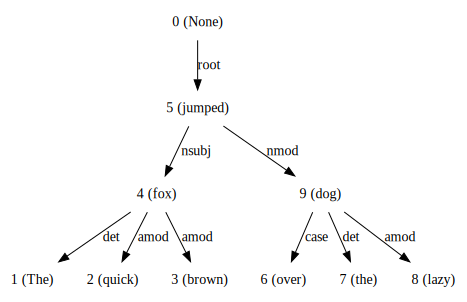

In [35]:
try:
    secondSentGraph = graphviz.Source(secondSentDepParseTree.to_dot())
except:
    secondSentGraph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
secondSentGraph

Or another sentence 

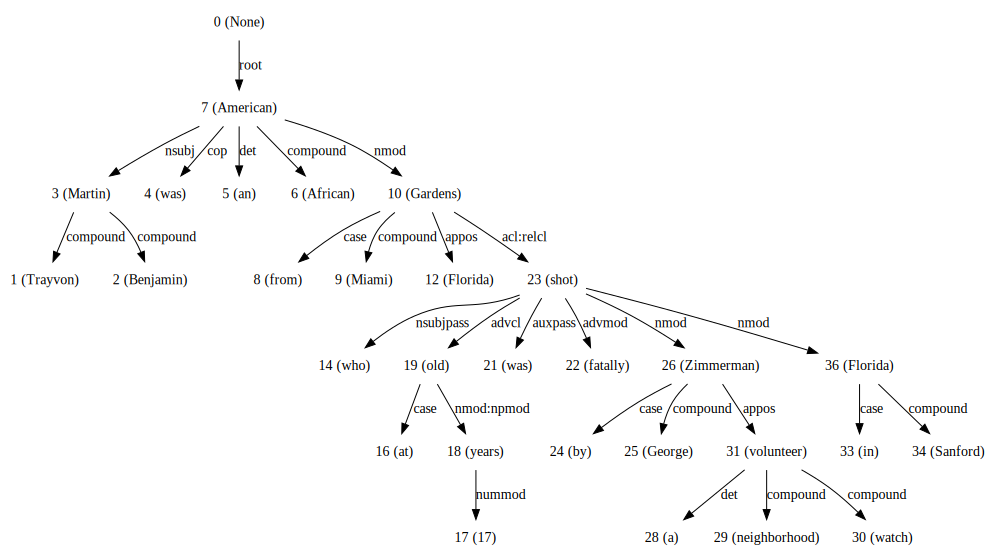

In [36]:
try:
    graph = graphviz.Source(list(depParses[3])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

We can also do a dependency parse on the reddit sentences:

In [37]:
topPostDepParse = list(stanford.depParser.parse_sents(redditTopScores['sentences'][0]))

This takes a few seconds, but now lets look at the parse tree from one of the processed sentences.

The sentence is:

In [38]:
targetSentence = 7
print(' '.join(redditTopScores['sentences'][0][targetSentence]))

So anyway , I get a call from an older gentleman who 's quite bitter and mean right off the bat ( does n't like that I asked for his address / telephone number to verify the account , hates that he has to speak with a machine before reaching an agent , etc . ) .


Which leads to a very rich dependancy tree:

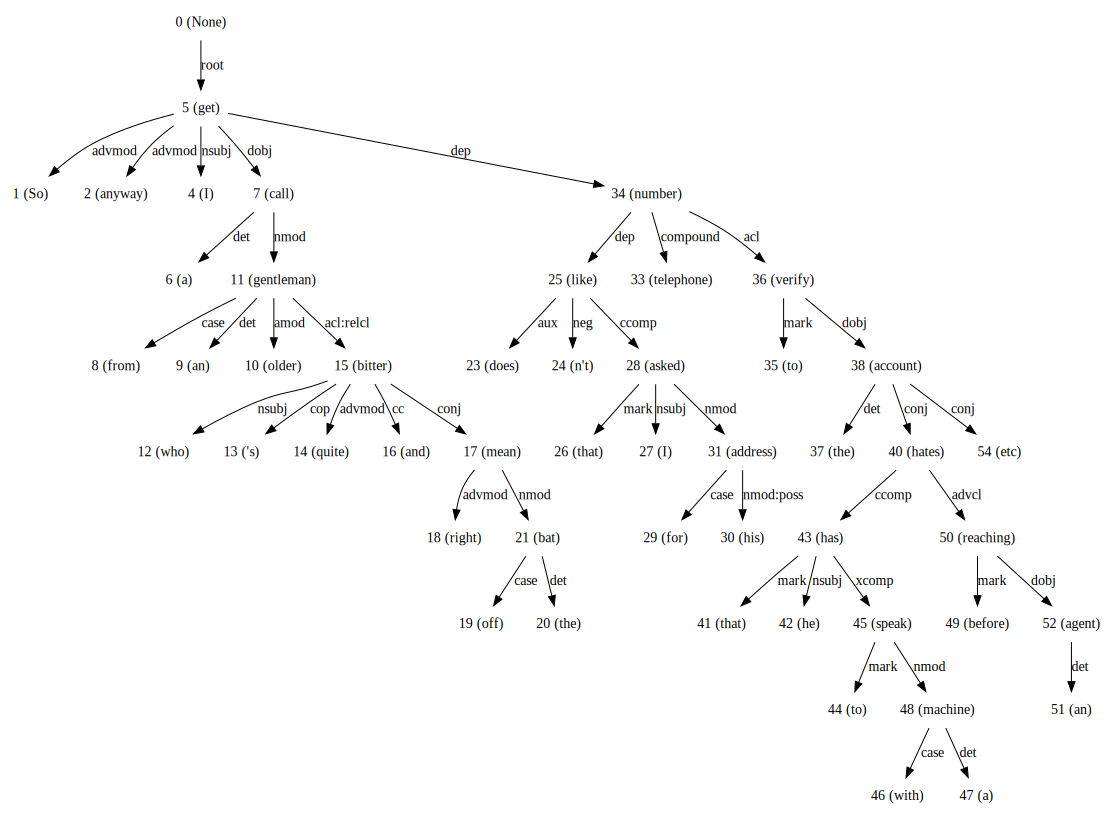

In [39]:
try:
    graph = graphviz.Source(list(topPostDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?

**How deep are the phrase structure and dependency parse trees nested?**

<i>Quite deep, it goes a few level down. However, as the length of the sentence is not too long there are not too much that can be extracted here.</i>

**How does parse depth relate to perceived sentence complexity?**

<i>The sentence is quite complex as it involves numerous social actors ('Tjahjo Kumolo', 'Basuki Tjahaja', 'FPI') and it reveals many of their social roles ('governor', 'minister', 'organization').</i>

**What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?**
<i>
1. The main idea of the sentence can be found by looking at NP (noun phrase) and 'Tjahaja' + 'the' = Jakarta governor Basuki 'Ahok ' Tjahaja Purnama has issued a letter recommending the disbandment of FPI.

2. Many tags reveal more or less similar things to the others. For example, NP + "Thahaja" and "NP" + "FPI" returns the same result despite having 2 different social actors. However, it might also be due to their dependency or connection to each other.

3. With graph representation, the dependency seems to be more apparent. Many social roles are revealed as they are represented more intuitively. For example, it is revealed through word compounding that 'Tjahjo Kumolo' is a 'minister' or that the 'organization' (refers to FPI) is a 'hard-line' group (hard-line modifies organization).

4. However, the graph identified 'Islamic Defender Front' and 'FPI' as 4 different things in different dependency levels instead of treating it as one entity.

5. It's interesting to look at branch number 27 in the graph where the word 'recommending' branches out into 'letter' and 'disbandment'. The word 'letter' leads to Ahok, which signals that he is the one who wrote the letter, and the word 'disbandment' branches out to the 'hard-line organization' (referring to FPI) as the subject in Ahok's letter.</i>

In [414]:
article = ["Home Minister Tjahjo Kumolo has said that his ministry is ready to follow up on acting Jakarta governor Basuki 'Ahok' Tjahaja Purnama's letter recommending the disbandment of hard-line organization the Islam Defenders Front (FPI).", "He explained that his ministry would follow up on the letter because the government should listen to every voice of the people and institutions in the archipelago.", "n Monday, Ahok, a Christian of Chinese descent, said that he would file the recommendation letter because the FPI's protests were offensive and in contravention of the 1945 Constitution."]

tokenized_article = [nltk.word_tokenize(t) for t in article]
print('\n'.join(article))

Home Minister Tjahjo Kumolo has said that his ministry is ready to follow up on acting Jakarta governor Basuki 'Ahok' Tjahaja Purnama's letter recommending the disbandment of hard-line organization the Islam Defenders Front (FPI).
He explained that his ministry would follow up on the letter because the government should listen to every voice of the people and institutions in the archipelago.
n Monday, Ahok, a Christian of Chinese descent, said that he would file the recommendation letter because the FPI's protests were offensive and in contravention of the 1945 Constitution.


In [415]:
parse = list(stanford.parser.parse_sents(tokenized_article)) #Converting the iterator to a list so we can call by index. They are still 
firstSentParseTree = list(parse[0]) #iterators so be careful about re-running code, without re-running this block
print(firstSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('NNP', ['Home']), Tree('NNP', ['Minister']), Tree('NNP', ['Tjahjo']), Tree('NNP', ['Kumolo'])]), Tree('VP', [Tree('VBZ', ['has']), Tree('VP', [Tree('VBN', ['said']), Tree('SBAR', [Tree('IN', ['that']), Tree('S', [Tree('NP', [Tree('PRP$', ['his']), Tree('NN', ['ministry'])]), Tree('VP', [Tree('VBZ', ['is']), Tree('ADJP', [Tree('JJ', ['ready']), Tree('S', [Tree('VP', [Tree('TO', ['to']), Tree('VP', [Tree('VB', ['follow']), Tree('PRT', [Tree('RP', ['up'])]), Tree('PP', [Tree('IN', ['on']), Tree('S', [Tree('VP', [Tree('VBG', ['acting']), Tree('NP', [Tree('NP', [Tree('NP', [Tree('NP', [Tree('NNP', ['Jakarta']), Tree('NNP', ['governor']), Tree('NNP', ['Basuki']), Tree('NN', ["'Ahok"]), Tree('POS', ["'"])]), Tree('NNP', ['Tjahaja']), Tree('NNP', ['Purnama']), Tree('POS', ["'s"])]), Tree('NN', ['letter'])]), Tree('VP', [Tree('VBG', ['recommending']), Tree('NP', [Tree('NP', [Tree('DT', ['the']), Tree('NN', ['disbandment'])]), Tree('PP', [Tree('IN', ['o

In [416]:
treeRelation(firstSentParseTree, 'NP', 'Tjahaja', 'the')

[[('NP',
   "Jakarta governor Basuki 'Ahok ' Tjahaja Purnama 's letter recommending the disbandment of hard-line organization the Islam Defenders Front FPI")]]

In [425]:
treeRelation(firstSentParseTree, 'VP', 'Basuki', 'the')

[[('VP',
   "has said that his ministry is ready to follow up on acting Jakarta governor Basuki 'Ahok ' Tjahaja Purnama 's letter recommending the disbandment of hard-line organization the Islam Defenders Front FPI")],
 [('VP',
   "said that his ministry is ready to follow up on acting Jakarta governor Basuki 'Ahok ' Tjahaja Purnama 's letter recommending the disbandment of hard-line organization the Islam Defenders Front FPI")],
 [('VP',
   "is ready to follow up on acting Jakarta governor Basuki 'Ahok ' Tjahaja Purnama 's letter recommending the disbandment of hard-line organization the Islam Defenders Front FPI")],
 [('VP',
   "to follow up on acting Jakarta governor Basuki 'Ahok ' Tjahaja Purnama 's letter recommending the disbandment of hard-line organization the Islam Defenders Front FPI")],
 [('VP',
   "follow up on acting Jakarta governor Basuki 'Ahok ' Tjahaja Purnama 's letter recommending the disbandment of hard-line organization the Islam Defenders Front FPI")],
 [('VP',
  

In [418]:
treeRelation(firstSentParseTree, 'NP', 'FPI', 'the')

[[('NP',
   "Jakarta governor Basuki 'Ahok ' Tjahaja Purnama 's letter recommending the disbandment of hard-line organization the Islam Defenders Front FPI")]]

In [419]:
treeRelation(firstSentParseTree, 'ADJP', 'FPI', 'the')

[[('ADJP',
   "ready to follow up on acting Jakarta governor Basuki 'Ahok ' Tjahaja Purnama 's letter recommending the disbandment of hard-line organization the Islam Defenders Front FPI")]]

In [420]:
firstSentParseTree[0].pretty_print()

                                                                                                                          ROOT                                                                                                                                             
                                                                                                                           |                                                                                                                                                
                                                                                                                           S                                                                                                                                               
         __________________________________________________________________________________________________________________|_______________________________________________________________________

<h3>Dependency parsing and graph representations</h3>

In [421]:
depParse = list(stanford.depParser.raw_parse_sents(article)) #Converting the iterator to a list so we can call by index. They are still 
firstSentDepParseTree = list(depParse[0])[0] #iterators so be careful about re-running code, without re-running this block
print(firstSentDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x110c3c6a8>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [6]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'NNP',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'compound',
                 'tag': 'NNP',
                 'word': 'Home'},
             2: {'address': 2,
                 'ctag': 'NNP',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'compound',
                 'tag': 'NNP',
        

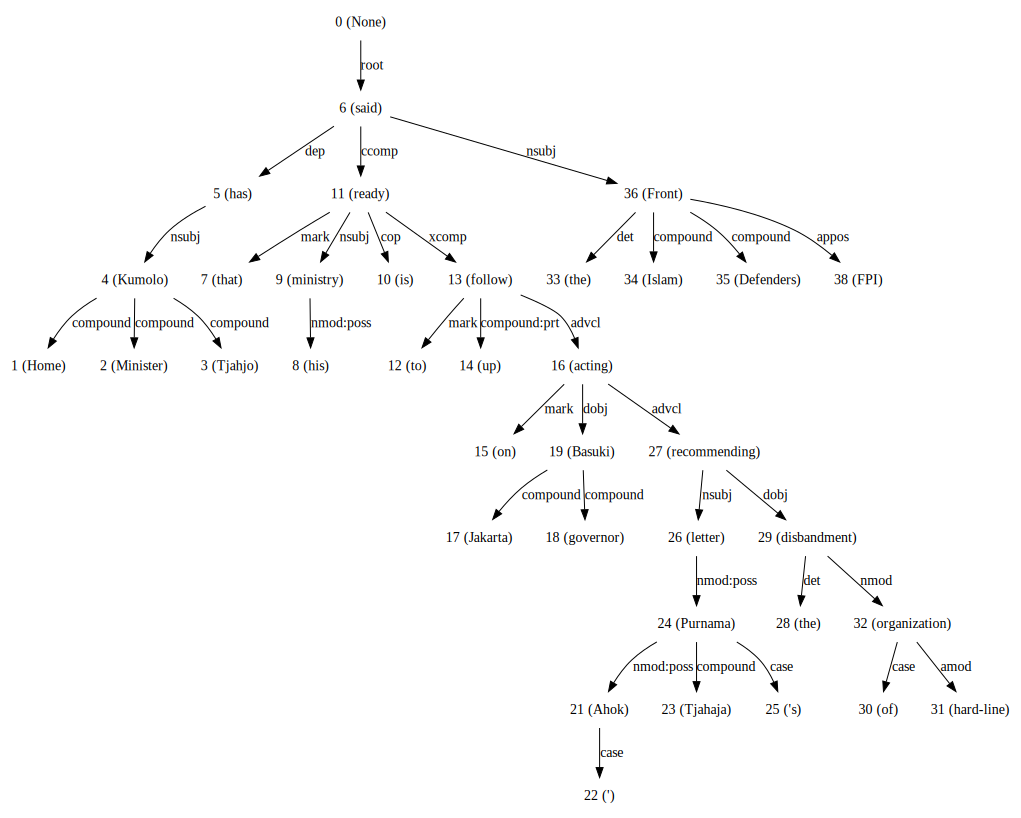

In [422]:
try:
    firstSentGraph = graphviz.Source(firstSentDepParseTree.to_dot())
except:
    firstSentGraph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
firstSentGraph

# Information extraction

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior. 

In [40]:
ieDF = stanford.openIE(text)

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.2 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 16.946 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [18.5 sec].
[main] INFO edu.stanford.nlp.pip

`openIE()` prints everything stanford core produces and we can see from looking at it that initializing the dependency parser takes most of the time, so calling the function will always take at least 12 seconds.

In [41]:
ieDF

,certainty,subject,verb,object
0,1.0,elephant,is in,my pajamas
1,1.0,I,saw,elephant in my pajamas
2,1.0,I,saw,elephant
3,1.0,quick brown fox,jumped over,lazy dog
4,1.0,quick brown fox,jumped over,dog
5,1.0,quick fox,jumped over,dog
6,1.0,fox,jumped over,dog
7,1.0,brown fox,jumped over,lazy dog
8,1.0,brown fox,jumped over,dog
9,1.0,quick fox,jumped over,lazy dog


No buffalos (because there were no verbs), but the rest is somewhat promising. Note, however, that it abandoned the key theme of the sentence about the tragic Trayvon Martin death ("fatally shot"), likely because it was buried so deeply within the complex phrase structure. This is obviously a challenge. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?) How could these approaches inform your research project?

**How could these approaches inform your research project?**<br>
<i>The analysis could show the social game in which social actors. For example, the way I did it was that 1) I identified the subjects mentioned in the text by coding:

    ie_DF['subject'].value_counts()

to look at the mot frequent subjects. 2) Then I looked at subjects that I am interested in and look at verbs that are related to them by coding:

    ie_DF[ie_DF['subject'] == 'demonstrators']['verb'].value_counts()

and 3) finally inferring the social game by looking at the subject and the verb.</i>

**<i>(!) For complete codes and explanation, please look at Exercise 5</i>**

In [ ]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

And we can also look for subject, object, target triples in one of the reddit stories.

In [42]:
ieDF = stanford.openIE(redditTopScores['text'][0])

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.2 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 16.627 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [18.3 sec].
[main] INFO edu.stanford.nlp.pip

In [43]:
ieDF

,certainty,subject,verb,object
0,1.000000,we,'ll get,calls
1,1.000000,we,Quite often 'll get,calls
2,1.000000,we,often 'll get,calls
3,0.831036,we,coax,direct to TV
4,0.774359,straight analog cable,coax,direct from wall
5,0.774359,analog cable,coax,direct from wall to TV
6,0.774359,straight analog cable,coax,direct to TV
7,1.000000,we,would supply analog cable to,homes
8,0.831036,we,coax,direct from wall
9,0.774359,analog cable,coax,direct from wall


That's almost 200 triples in only:

In [44]:
len(redditTopScores['sentences'][0])

37

sentences and

In [45]:
sum([len(s) for s in redditTopScores['sentences'][0]])

971

words.

Lets find at the most common subject in this story.

In [46]:
ieDF['subject'].value_counts()

I                        48
it                       42
he                       19
He                       18
we                       11
old man                   8
man                       8
letter                    4
straight analog cable     4
call                      4
our booking calendar      4
analog cable              4
my supervisor             3
you                       2
TV                        2
his TV set                2
they                      2
our equipment             1
me                        1
handling                  1
people                    1
our digital equipment     1
repeat offenders          1
Name: subject, dtype: int64

I is followed by various male pronouns and compound nouns (e.g., "old man"). 'I' occures most often with the following verbs:

In [178]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

could come                        8
even brought                      5
brought                           5
was                               4
had                               4
speak for                         3
instantly felt                    1
get to                            1
still think about                 1
felt                              1
think about                       1
anyway get                        1
complaint in                      1
took                              1
get                               1
've dealt with                    1
eventually had                    1
had cable within                  1
have                              1
think occasionally about          1
do                                1
still think occasionally about    1
speak with                        1
ask                               1
So anyway get                     1
Name: verb, dtype: int64

and the following objects

In [177]:
ieDF[ieDF['subject'] == 'I']['object'].value_counts()

Mr. Smith                                             4
him                                                   3
call                                                  3
simplified remote                                     2
simplified remote for his set top box                 2
remote for his set top box                            2
get                                                   2
this                                                  2
bad                                                   2
remote                                                2
willing                                               2
speak for bit about account for Mr. Smith             1
cable running again                                   1
residence                                             1
speak with her for bit about account                  1
experience                                            1
bit                                                   1
it                                              

We can also run the corenlp server. When you run this server (with the command below), you can click on the browswer link provided to experiment with it. Note that when we run the server, executing the command below, it interrupts the current jupyter process and you will not be able to run code here again (processes will "hang" and never finish) until you interrup the process by clicking "Kernel" and then "Interrupt".

In [49]:
stanford.startCoreServer()

Starting server on http://localhost:16432 , please wait a few seconds
click Kernel -> Then Interupt to stop     (･ω･｀)))                    
Exiting (ノ≧▽≦)ノ


## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa. Describe how you would select among these statements to create a database of high-value statements for your project and then do it by extracting relevant statements into a pandas dataframe.

<h3>Analyzing the Relative Attachment of Subjects + Verbs / Objects</h3>

We will be looking at an article pertinent to FPI.

To look at high-value statements I extracted relevant statements by:<br>
1) identifying subjects to look at political actors of interest; and the<br>
2) verbs / objects to understand how these actors behave (verbs) and what are the objects the are acting upon.

**Findings:**<br>
<i>The subject value count performed below mentions 'demonstrators', which signals that we are looking at an event of demonstration. From the 10 sentences that I have analyzed I looked at 2 subjects 'Ahok', a governor in Indonesian capital city, and the 'demonstrators' (FPI members). From the analysis we could see that Ahok is of a Chinese descent (an important factor, as FPI framed him as a 'foreigner' and thus is not fit to govern the capital city) and the word 'must ousted' reflects the demonstrants' demand upon Ahok. Furthermore, a verb related to the demonstrators is 'were received by', which shows how the government attempted to listen to their demands in a peaceful manner instead of breaking the demonstration.

This exchange revealed by the information extraction shows the social game played by FPI and the government: FPI's contentious politics against the government.</i>

In [237]:
ie_DF = stanford.openIE(FPIRandom['Article'][0])

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 18.047 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [19.7 sec].
[main] INFO edu.stanford.nlp.pip

In [238]:
ie_DF

,certainty,subject,verb,object
0,1.000000,Jakarta governor Basuki,' ÛÏAhok is,Ûªs letter recommending
1,1.000000,his ministry,follow up on,letter
2,1.000000,ÛÏI haven Ûªt,read,letter
3,0.854793,Ahok,Christian of,Chinese descent
4,1.000000,Ahok,said On,Monday
5,1.000000,Ahok,Christian of,Chinese descent
6,1.000000,devil ' Ûªs,is spawn such as,ÛÏAhok
7,1.000000,ÛÏArrogant Ahok,must,must ousted
8,1.000000,Ahok,must,must ousted
9,1.000000,demonstrators,were received by,Abraham ' ÛÏLulung


In [239]:
len(FPIRandom['sentences'][0])

10

In [240]:
sum([len(s) for s in FPIRandom['sentences'][0]])

261

In [241]:
ie_DF['subject'].value_counts()

Ahok                       4
demonstrators              3
Lulung                     2
Taufik                     2
his ministry               1
Jakarta governor Basuki    1
Û Lunggana                 1
ÛÏI haven Ûªt              1
ÛÏArrogant Ahok            1
devil ' Ûªs                1
Name: subject, dtype: int64

In [242]:
ie_DF[ie_DF['subject'] == 'Ahok']['object'].value_counts()

Chinese descent    2
must ousted        1
Monday             1
Name: object, dtype: int64

In [244]:
ie_DF[ie_DF['subject'] == 'Ahok']['verb'].value_counts()

Christian of    2
said On         1
must            1
Name: verb, dtype: int64

In [245]:
ie_DF[ie_DF['subject'] == 'demonstrators']['object'].value_counts()

Abraham ' ÛÏLulung respectively    1
Abraham ' ÛÏLulung                 1
received                           1
Name: object, dtype: int64

In [246]:
ie_DF[ie_DF['subject'] == 'demonstrators']['verb'].value_counts()

were received by    2
were                1
Name: verb, dtype: int64